# Probabilistic Linear Discriminant Analysis

It is called generative model because the model generates x (the sample of an specific class)

Transforms an X into a space where the within-class variance is unit and between-class variance is diagonalized.

PLDA is a probability generation model originally proposed for solving face recognition and verification problems [3, 5], and has since been widely used in pattern recognition tasks such as voiceprint recognition.

PLDA assumes that the centers are subject to a continuous distribution (Gaussian distribution). Therefore, PLDA can be extended to unknown categories for identification and authentication of unknown categories.

Assumed data x Satisfy the following probability relationships:

P(x|y) = N(x|y,\Phi_w) and P(y) = N(y|m,\Phi_b)


The probability of not belonging to any known class is: 

P(u_new| 0) = N(u_new| 0, \Psi + I)

It is comonly used in biometric authentication
Are the best performance for face n speaker 

Motivations

refs: https://ravisoji.com/assets/papers/Ioffe2006PLDA.pdf (abstract)

1. Fisher LDA is common used in object recognition for feature extraction, but do not address the problem of how to use these features for recognition.
2. latent variables of PLDA (PLDA components) represent both: the class of the object and the within variability  variability class of the object.
3. Automatic give more wieght of the features with the most discriminativy power
4. Can build a model of unseen class with only one example or  can combine multiple examples for a better representation of the class



Assumptions of PLDA:

1. All classes are normal distributed: $P(x \mid y) = N(x \mid y,\Phi_w)$
     where y is label
2. All class has the same covariance matrix $\Phi_w$
3. n_k = n const: Each class has the same number of samples. Case it is not true, resample the class in order to have all class with the same number of observations

The solution has the constraints:
1. $\Phi_w$ is positive defined
2. The priori $P(y) = N(y \mid 0,\Phi_b)$ is normal distributed
3. $\Phi_b$ is semi-positive defined

Application:

* Speaker recognition
* Face recogintion

We show applications to classification, hypothesis testing,
class inference, and clustering, on classes not observed during training.

###  Small discussion about how LDA works (Can be skipped)

The goal of (PLDA) is to find best new set of axis that maximizes the distance between the means of the classes and also minimize overlap between the projected classes (confusion region). 

The figures below describe LDA being applied to a bidimensional dataset containing 2 classes. 

The dataset is a set of $n$ d-dimensional samples $X = \{x_1, x_2, ..., x_n\}$ already labeled in 2 groups: 
$X^{(k)} = \{ x_1^{(k)},  x_2^{(k)}, ..., x_{n_k}^{(k)} \}$ of size $n_k$ for $k = 1,2$ where $x_i^{(k)}$ is a vector of dimension $d$.


In order to do that, Fisher proposed to maximize the ratio "scattter between classes/scatter within classes" that is expressed by the Cost function:

$
J(v) = \frac{v^t S_{b} v}{ v^t S_{v}  v}
$

where:

* $S_b= \frac{1}{N} \sum_k=1^K n_k (m_k - m)( m_k - m)^t$ :  between-class covariance/satter matrix. (Can be understood as measure of between class spread)
    
* $S_{w} = \frac{1}{N} \sum_k=1^K S_k$ : within-class covariance/scatter matrices. (Can be understood as measure of within class spread or the sum of the spread matrix of each class) 

$ m_k$ is the mean of each class. $m$ is the global mean. and $S_k$ is the apread matrix of each class giben by:

$
S_k = \sum_{x_i\in X^{(k)}} ( x_i^{(k)} -  m_k) ( x_i^{(k)} - m_k)^t  
$

The spread matrix are related to the covariance matrx by the equation:


$
\Sigma_k = \frac{1}{N_k -1}S_k  
$


The total scatter is given by:

$
S_t = S_W + S_B
$

But can also be expressed as:

$
S_t = \sum_{j=1}^{n}(x_j - m)(x_j - m)^t \equiv \sum_{k=1}^2 \sum_{i=1}^{n_k}(x_i^{(k)} - m)(x_i^{(k)} - m)^t = S_w + S_b
$

$
n = \sum_{k=1}^2 n_k
$

Can be proved in  [here](refs/ea71fbef3b55b69e142897fadf43b3269463.pdf) and [here](refs/Dimensionality2.pdf) that maximize $J(v)$ is equivalent to find the solution of the eigenvalue problem for the matrix:

$
A =  S_{w}^{-1} S_b
$

$
A{v} =  \lambda {v}
$

where:
* $v$ is the eigenvector and define the new axes
* $\lambda$ is the eigenvalue

### Summarizing the LDA approach in 5 steps

1. Compute Fisher LDA parameters 
2. Update parameters 
    * between-class: measure of dispersion between groups or classes
    * within-class scatter matrix: measure of dispersion in the class or group
3. Reduce dimensionality



In [127]:
import numpy as np
import pandas as pd
import random as rand
import math
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)

import bob.learn.em

from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA as sklearnPCA

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

ModuleNotFoundError: No module named 'bob'

load data

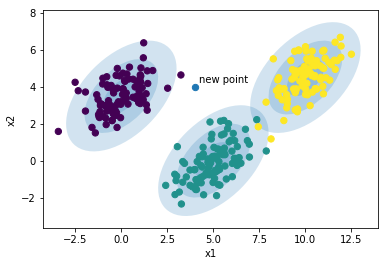

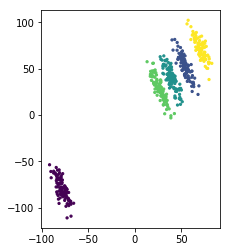

array([0, 1, 2, 3, 4])

500

100

,x,y,label
419,70.666011,71.299763,4
98,-78.912518,-80.436834,0
235,49.556942,28.715026,2
421,74.141707,60.310675,4
166,47.121866,62.181778,1


In [102]:
%run ../simulated_plda_data.ipynb

X = df[['x','y']].values
N = X.shape[0]
y = df.label

df.label.unique()


X1 = df.loc[df.label ==1,['x','y']].values
nk = X1.shape[0]

N
nk

df.sample(5).head(5)

In [103]:
def estimate_gaussian_parameters(Xk):

    mk = np.mean(Xk,axis=0)
    Sk = np.cov(Xk[:,0],Xk[:,1])
    
    return mk, Sk

def get_plda_paramaters(Xk,N):
    
    Nk = Xk.shape[0]
    
    pik = Nk/N
    
    mk, Sk = estimate_gaussian_parameters(Xk)
    
    Sk_inv = np.linalg.inv(Sk)
    
    return Sk_inv, pik

def lda_score(X_new,mk, Sk,Sk_inv, pik):
    
    scorek = -0.2*np.log(np.linalg.det(Sk)) 
    uk = X_new - mk
    Ak = np.matmul(Sk_inv,uk.T)
    scorek = scorek - 0.5*np.matmul(uk,Ak) 
    scorek += np.log(pik)
    
    return scorek

def compute_scatter_matrixes(X,labels,nk):
    
    d = X.shape[1]
    N = X.shape[0]
    
    m = np.mean(X,axis=0)
    
    Sw = np.zeros((d,d))
    Sb = np.zeros((d,d))
    
    for label in labels:
    
        Xk = np.squeeze(X[np.argwhere(y == label)])
        mk, Sk = estimate_gaussian_parameters(Xk)
        
        # within spread matrix
        Sw = np.add(Sw,(nk -1)*Sk/N)
        
        # between spread matrix
        dmk = np.add(mk,-m)
        dmk = dmk[np.newaxis].transpose()

        Sb = np.add(Sb, nk/N*np.matmul(dmk, dmk.transpose()))
    
    return Sw, Sb
    
def diagnolize_matrix(M, W):
    
    M_diag = np.matmul(W.T,np.matmul(M,W))
    M_diag = np.diag(M_diag.diagonal())
    
    return M_diag
    
def compute_transformation_matrix(Sw,Sb,nk):
    
    Sw_inv = np.linalg.inv(Sw)
    d = Sw.shape[0]
     
    S = np.matmul(Sw_inv, Sb)
    eigen_values, W = np.linalg.eigh(S)
        
    # projected/diagnolized within spread matrix: projecting Sw
    Lambda_w = diagnolize_matrix(Sw,W)
  
    weight = nk/(nk - 1.0)
    
    Lambda_w_weighted = weight*Lambda_w
    # prevent small negative numbers due to numerical error
    Lambda_w_weighted[np.isclose(Lambda_w_weighted, 0.0)] = 0.0
    Lambda_w_weighted = np.sqrt(Lambda_w_weighted)
    
    W_transposed_inv = np.linalg.inv(W).T
    
    A = np.matmul(W_transposed_inv, Lambda_w_weighted)
    
    return A, W

def compute_transformed_between_covariance(Lambda_w,Lambda_b,nk):
    
    weight = (nk - 1)/nk
    
    with np.errstate(divide='ignore', invalid='ignore'):
         Psi_diagonal = weight * Lambda_b.diagonal() / Lambda_w.diagonal()

    Psi_diagonal[np.isnan(Psi_diagonal)] = 0.0
    Psi_diagonal = Psi_diagonal - 1.0/nk
    
    # max(0, Psi)
    Psi_diagonal[Psi_diagonal < 0.0] = 0.0
    
    Psi_diagonal[np.isinf(Psi_diagonal)] = 0.0
    Psi = np.diag(Psi_diagonal)

    return Psi


def plda_fit(X, labels):
   
    N = X.shape[0]
    K = np.size(np.unique(labels)) #labels.nunique()
    nk = N/K
    
    global_mean = np.mean(X,axis=0)
    
    Sw, Sb = compute_scatter_matrixes(X,np.unique(labels),nk)
    
    A, W = compute_transformation_matrix(Sw,Sb,nk)
    
    Lambda_w = diagnolize_matrix(Sw,W)
    Lambda_b = diagnolize_matrix(Sb,W)
    
    # The within trasnformed covariance is Identity matrix
    Psi = compute_transformed_between_covariance(Lambda_w,Lambda_b,nk)
   
    return global_mean, A, Psi

def project_data(z):
    
    z_tranformed = np.matmul(A_inv,z - global_mean)
    
    return z_tranformed

def plda_predict(x_new):
    
    # u' = A^{-1}(x - m)
    u_new = project_data(x_new)
    
    for y in labels:
        
        u_avg = comp
        score = _compute_posterior_probability()
        
    return score

In [104]:
Sw,Sb = compute_scatter_matrixes(X,y.unique(),nk)

Sw

Sb

array([[ 28.9906, -52.5728],
       [-52.5728, 139.6685]])

array([[2779.8685, 2788.6271],
       [2788.6271, 2798.6723]])

In [105]:
A, W = compute_transformation_matrix(Sw,Sb, nk)
W
A

array([[ 0.4689, -0.8833],
       [-0.8833, -0.4689]])

array([[  5.9397,  -2.7757],
       [-11.1896,  -1.4734]])

In [106]:
Lambda_w = diagnolize_matrix(Sw,W)
Lambda_b = diagnolize_matrix(Sb,W)

Psi = compute_transformed_between_covariance(Lambda_w,Lambda_b,nk)

print('Lambdas')
Lambda_w
Lambda_b

Phi_w = np.matmul(A,A.T)
Phi_b = np.matmul(A,np.matmul(Psi,A.T))

print('Phis')
Phi_w
Phi_b

Psi

Lambdas


array([[158.8822,   0.    ],
       [  0.    ,   9.7769]])

array([[ 484.8165,    0.    ],
       [   0.    , 5093.7243]])

Phis


array([[ 42.9848, -62.3731],
       [-62.3731, 127.3779]])

array([[4080.1105, 1909.3221],
       [1909.3221, 1496.7267]])

array([[  3.0109,   0.    ],
       [  0.    , 515.7765]])

In [107]:
(Phi_w - (nk)/(nk -1)*Sw)/Phi_w


array([[ 0.3187,  0.1486],
       [ 0.1486, -0.1076]])

In [108]:
m, A, Psi = plda_fit(X, y)

m
A
Psi

array([22.6366, 22.3433])

array([[  5.9397,  -2.7757],
       [-11.1896,  -1.4734]])

array([[  3.0109,   0.    ],
       [  0.    , 515.7765]])

In [109]:
## double check transformations

u1 = np.matmul(W.T,x_new)

A_inv = np.linalg.inv(A)

u2 = np.matmul(A_inv,x_new - m)

np.dot(u1,u2)

np.matmul(u1,u2.T)

# u1 n u2 are orthogonal


np.arccos(np.matmul(u1/np.linalg.norm(u1),u2.T/np.linalg.norm(u2)))/np.pi

-44.10933472991256

-44.10933472991256

0.9288102649910596

In [110]:
St = (N - 1.0)* np.cov(X[:,0],X[:,1])

u = np.add(X,-m).transpose()
S_hat = np.matmul(u,u.transpose())

St - S_hat

N*Sw + N*Sb

St

S_hat

array([[ 0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -2.3283e-10]])

array([[1404429.5325, 1368027.1627],
       [1368027.1627, 1469170.408 ]])

array([[1404429.5325, 1368027.1627],
       [1368027.1627, 1469170.408 ]])

array([[1404429.5325, 1368027.1627],
       [1368027.1627, 1469170.408 ]])

## Verification of the equations on the first sections

For the verification of the formulas cited in the firsts sections (See: [Small discussion about how LDA works (Can be skipped)]()), we are going to compute all matrix: $\hat{\Sigma_1}$, $\hat{\Sigma_2}$ and $S_t$ and compare with the global covariance matrix of the data (the spread of the data conserves) $\hat{\Sigma}$. Also because we generated the data using two multivariate Gaussians, we know the true values of the parameters $\Sigma_1$ and $\Sigma_2$ and we can compare with our estimations of this parameters.

* Estimating the covariances Matrix

Computing $\hat{\Sigma_k}$ and comparing with the true values $\Sigma_k$


array([[11.3334,  0.    ],
       [ 0.    , 95.8518]])

array([-4.,  1.])

numpy.ndarray

(3, 2)

array([[ 1.3112,  5.9898],
       [-1.2001, -0.3257],
       [-0.1111, -5.6641]])

array([[ 3.1717,  8.8735],
       [ 8.8735, 68.0659]])

mk: [1.3112 5.9898]
uk.shape: (100, 2)
mk: [-1.2001 -0.3257]
uk.shape: (100, 2)
mk: [-0.1111 -5.6641]
uk.shape: (100, 2)


(300, 2)

(array([ 1.,  4.,  6., 12., 19., 22., 11., 16.,  6.,  2.]),
 array([-8.3442, -7.8336, -7.323 , -6.8124, -6.3018, -5.7911, -5.2805,
        -4.7699, -4.2593, -3.7487, -3.2381]),
 <a list of 10 Patch objects>)

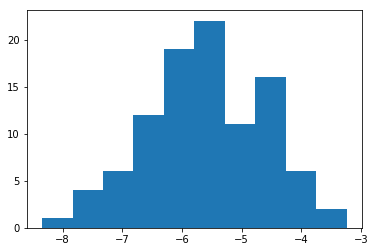

In [119]:
from numpy.random import multivariate_normal
def gen_Psi():
    """ Diagonal matrix describing the covariance between clusters.
    """
    np.random.seed(2018)
    d = 2
    Psi = np.diag(10.0/np.random.sample(d))

    return Psi

def gen_global_mean():
    
    d = 2
    m = np.random.randint(-10.0, 10.0, d).astype(float)
    
    return m

def gen_V_space(Psi):
    # v ~ N(v|0,Psi)

    n_class = 3
    d = Psi.shape[0]
    
    V = multivariate_normal(np.zeros(d),Psi,n_class)
    V = V - V.mean(axis=0)
    
    return V
    
def gen_U_space(V):
     # u ~ N(u|v,1)
    
    n_class = V.shape[0]
    d = V.shape[1]
    
    nk = 100

    U = []
    for k in range(0,n_class):
        
        mk = V[k,:]
        print('mk: {}'.format(mk))
        uk = multivariate_normal(mk,np.diag([1.0 , 1.0]),nk)
        print('uk.shape: {}'.format(uk.shape))
        U.append(uk)
    
    
    U = np.vstack(U)
    return U 


def gen_A(V):
    """ A = [B][inv(Λ ** .5)][Q^T] and assumes same number of data
             in each class v. 
    """
    d = V.shape[1]
    
    np.random.seed(2018)
    B = np.random.randint(-100, 100, (d, d)).astype(float)
    
    print(B)
    
    big_V = np.matmul(V.T, V)  # V is now a scatter matrix.
    
    print('bigV')
    print(big_V)
    
    vals, vecs = np.linalg.eig(big_V)
    
    
    print('eigen vector values')
    print(vals)
    print(vecs)
    
    A = B / np.sqrt(vals.real)
    
    print('partial A')
    print(A)
    A = np.matmul(A, vecs.T)
    
    return A


Psi = gen_Psi()
Psi

m = gen_global_mean()
m
type(m)


V = gen_V_space(Psi)
V.shape

V

np.matmul(V.T, V)

U = gen_U_space(V)
U.shape

ax = plt.gca()
ax.hist(U[201:300,1])

In [120]:
A = gen_A(V)
A

[[  2. -91.]
 [ 49.  56.]]
bigV
[[ 3.1717  8.8735]
 [ 8.8735 68.0659]]
eigen vector values
[ 1.9802 69.2574]
[[-0.9911 -0.1331]
 [ 0.1331 -0.9911]]
partial A
[[  1.4213 -10.9347]
 [ 34.8209   6.7291]]


array([[  0.0466,  11.0266],
       [-35.4067,  -2.0353]])

In [121]:
A_inv = np.linalg.inv(A)

np.matmul(A_inv,A)

Au =  np.matmul(A, U.T).T
X = m + Au
X.shape

array([[ 1.0000e+00,  1.3767e-17],
       [-5.9968e-19,  1.0000e+00]])

(300, 2)

In [125]:
# Tranformed centorid os each class (Good for verofocation)

Av =  np.matmul(A, V.T).T
Y = m + Av 
Y.shape

Y

V

X1 = X[0:100,:]
x_bar = np.mean(X1,axis=0)


# Comparing the true parameter Y_1 with the estimation of this parmeter
Y[0,:]
x_bar

(Y[0,:] - x_bar)/Y[0,:]

B = np.linalg.inv(np.add(Psi,np.identity(2)))

v_hat = np.matmul(B,np.matmul(Psi,U[0,:]))

v_hat

(V[0,:] - v_hat)/V[0,:]

(3, 2)

array([[ 62.1082, -57.6148],
       [ -7.6469,  44.154 ],
       [-66.4613,  16.4608]])

array([[ 1.3112,  5.9898],
       [-1.2001, -0.3257],
       [-0.1111, -5.6641]])

array([ 62.1082, -57.6148])

array([ 60.9195, -57.0561])

array([0.0191, 0.0097])

array([1.6737, 5.7645])

array([-0.2765,  0.0376])

(-4.139122947207262, 4.038255788077333, -9.171561312485261, 8.711185541261)

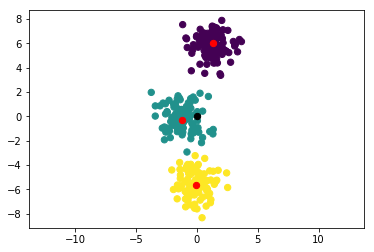

In [95]:
U_labels = ([1] * 100) + ([2] * 100) + ([3] * 100)

ax = plt.gca()
ax.scatter(U[:, 0], U[:, 1], c=U_labels, s=40, cmap='viridis', zorder=2)
ax.scatter(V[:, 0], V[:, 1], c='red', s=40, cmap='viridis', zorder=2)
ax.scatter(0, 0, c='black', s=40, cmap='viridis', zorder=2)
ax.axis('equal')

(-104.9495452087182, 91.98765141498923, -154.55663666419744, 143.6250487471396)

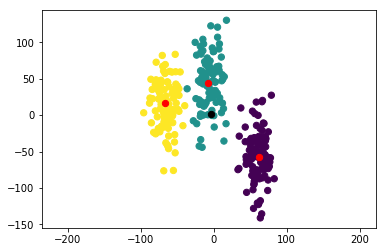

In [96]:
ax = plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=U_labels, s=40, cmap='viridis', zorder=2)
ax.scatter(Y[:, 0], Y[:, 1], c='red', s=40, cmap='viridis', zorder=2)
ax.scatter(m[0], m[1], c='black', s=40, cmap='viridis', zorder=2)
ax.axis('equal')

In [97]:
y = np.array(U_labels)


plda_m, plda_A, plda_Psi = plda_fit(X, y)

print('A')
A
plda_A

print('Psi')
Psi
plda_Psi

A


array([[  0.0466,  11.0266],
       [-35.4067,  -2.0353]])

array([[ -2.2439, -11.0328],
       [-34.3998,   0.7197]])

Psi


array([[11.3334,  0.    ],
       [ 0.    , 95.8518]])

array([[ 1.3417,  0.    ],
       [ 0.    , 23.5318]])

In [129]:
plda_Phi_w = np.matmul(plda_A,plda_A.T)
plda_Phi_w


X1 = X[0:100,:]
X2 = X[100:200,:]
X3 = X[200:300,:]

print('S1')
S1 = np.cov(X1[:,0],X1[:,1])
S1

print('S2')
S2 = np.cov(X2[:,0],X2[:,1])
S2

print('S3')
S3 = np.cov(X3[:,0],X3[:,1])
S3

print('AVG: (S1 + S2 + S3)/3')
S_avg  = (S1 + S2 + S3)/3


S_avg

(plda_Phi_w - S_avg)/plda_Phi_w

array([[ 126.757 ,   69.2494],
       [  69.2494, 1183.8626]])

S1


array([[ 106.4194,   -3.3938],
       [  -3.3938, 1192.1583]])

S2


array([[ 126.4436,   37.1527],
       [  37.1527, 1324.9953]])

S3


array([[ 122.089 ,  -19.2595],
       [ -19.2595, 1059.7529]])

AVG: (S1 + S2 + S3)/3


array([[ 118.3174,    4.8331],
       [   4.8331, 1192.3022]])

array([[ 0.0666,  0.9302],
       [ 0.9302, -0.0071]])